In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from string import punctuation
print(punctuation)
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


clean the original data

In [2]:
df = pd.read_csv("SET_processed_latest_version.csv")
for i in range(df.shape[1]):
    df.iloc[:,i]= df.iloc[:,i].replace([555, 777,888,999,'555','777','888','999' ], np.nan)
text=df.loc[:,['GRYD_ETO_ID','S6b_Other_Activities','S11a_Comments','A1_Description','A2_Description','A3_Description','O1_other_group_name','Group_name_part1','PUSH_1','PULL_1']]
text["text_all"] = text.apply(lambda x: ','.join(x.dropna()), axis=1)


normalize function

In [3]:
import re, string

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [4]:
from nltk.corpus import stopwords
sw = stopwords.words('english')

def  normalize (df):
    contents=df.dropna().values
    

    
    
    for i in range (contents.shape[0]):
        contents[i]=contents[i].replace(",", " ")
        
    all_contents = [''.join([c for c in i if c not in punctuation]) for i in contents]
    all_contents = [i.lower() for i in all_contents]
    all_contents= [i.split() for i in all_contents]
    
    for i in range (len(all_contents)):
        all_contents[i]=remove_noise(all_contents[i],sw)
    
    
    clean_tokens = [[] for _ in range(len(all_contents))]
    other_trash = ['im','a','u','2','wont','thats','dont', 'cant', 'didnt','isnt','ive','doesnt']
    trash_tokens = sw + other_trash
    for i in range(len(all_contents)):
        for token in all_contents[i]:
            if token not in trash_tokens:
                clean_tokens[i].append(token)
       
    

    
    return clean_tokens

In [5]:
original = normalize(text['S11a_Comments'])

combine data + sample data exploration

In [6]:
df=pd.read_csv("tweet_dataset.csv")

In [7]:
df=df.loc[:,['sentiment','selected_text']]

In [8]:
df1=pd.read_csv('data_train.csv')

In [9]:
df2=pd.read_csv('data_test.csv')

In [10]:
df=pd.concat([df1, df2], ignore_index=True)

In [11]:
df=df.rename(columns={'Emotion':'sentiment','Text':'selected_text'})

In [12]:
df.shape

(11327, 2)

In [13]:
print(df.sentiment.value_counts())

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: sentiment, dtype: int64


In [14]:
fear = normalize(df.loc[df['sentiment']=='fear']['selected_text'])
sadness = normalize(df.loc[df['sentiment']=='sadness']['selected_text'])
neutral = normalize(df.loc[df['sentiment']=='neutral']['selected_text'])
joy = normalize(df.loc[df['sentiment']=='joy']['selected_text'])


anger = normalize(df.loc[df['sentiment']=='anger']['selected_text'])

most common tokens for sadness categories

In [15]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token
sadness_words = get_all_words(sadness)

In [16]:
from nltk import FreqDist

freq_dist_pos = FreqDist(sadness_words)
print(freq_dist_pos.most_common(100))

[('friend', 248), ('sad', 234), ('die', 219), ('sorry', 211), ('go', 198), ('felt', 173), ('’', 164), ('time', 154), ('know', 151), ('get', 148), ('year', 125), ('one', 122), ('leave', 122), ('day', 106), ('think', 104), ('away', 100), ('feel', 99), ('father', 99), ('mother', 98), ('make', 96), ('death', 95), ('say', 95), ('tell', 92), ('would', 91), ('come', 88), ('home', 87), ('close', 87), ('could', 86), ('really', 85), ('find', 83), ('see', 76), ('hear', 75), ('pass', 74), ('like', 72), ('look', 72), ('love', 70), ('last', 70), ('back', 67), ('oh', 67), ('lose', 66), ('much', 64), ('want', 64), ('family', 63), ('well', 63), ('boyfriend', 61), ('bad', 61), ('take', 60), ('first', 59), ('work', 59), ('grandmother', 59), ('good', 57), ('long', 56), ('ill', 56), ('miserable', 54), ('parent', 53), ('fail', 53), ('give', 53), ('relationship', 51), ('mine', 51), ('school', 50), ('sadness', 50), ('grief', 49), ('girlfriend', 49), ('old', 48), ('grandfather', 48), ('month', 46), ('try', 46)

change the data type to fit the naive bayes model

In [17]:
def get_tweets_for_model(cleaned_tokens_list):
    
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)



In [18]:
fear_new = get_tweets_for_model(fear)
sadness_new = get_tweets_for_model(sadness)
neutral_new = get_tweets_for_model(neutral)
joy_new = get_tweets_for_model(joy)


anger_new = get_tweets_for_model(anger)

In [19]:
import random
fear_data = [(i, "fear")for i in fear_new]
sadness_data = [(i, "sadness")for i in sadness_new]
neutral_data = [(i, "neutral")for i in neutral_new]
joy_data = [(i, "joy")for i in joy_new]


anger_data = [(i, "anger")for i in anger_new]

In [20]:
anger_data[0]

({'dislike': True,
  'intimacy': True,
  'show': True,
  'towards': True,
  'resentful': True,
  'memory': True,
  'share': True,
  'part': True,
  'felt': True,
  'exclude': True},
 'anger')

train test split, fit naive bayes model

In [21]:
dataset = fear_data+ sadness_data +neutral_data+joy_data+anger_data

len(dataset)


11327

In [22]:
random.shuffle(dataset)

train_data = dataset[:9000]
test_data = dataset[9000:]

In [23]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.5969058874086807
Most Informative Features
                     sad = True           sadnes : joy    =    125.3 : 1.0
                   sorry = True           sadnes : joy    =    112.1 : 1.0
                     die = True           sadnes : neutra =    111.3 : 1.0
                    fear = True             fear : neutra =    103.2 : 1.0
                    felt = True           sadnes : neutra =     86.4 : 1.0
                   night = True             fear : neutra =     57.4 : 1.0
                   happy = True              joy : anger  =     56.1 : 1.0
                   angry = True            anger : joy    =     53.7 : 1.0
                   anger = True            anger : fear   =     53.3 : 1.0
                 delight = True              joy : sadnes =     49.7 : 1.0
None


In [24]:
print(classifier.classify(dict([token, True] for token in original[10])))

sadness


add sentiment column to original text df

In [25]:
sentiment=list()
for i in range (len(original)):
    sentiment.append(classifier.classify(dict([token, True] for token in original[i])))

In [26]:
text['sentiment']=np.nan
text.head()

,GRYD_ETO_ID,S6b_Other_Activities,S11a_Comments,A1_Description,A2_Description,A3_Description,O1_other_group_name,Group_name_part1,PUSH_1,PULL_1,text_all,sentiment
0,BVCB-0-144-1,"Working out, CBT, boxing","School. Poor grades, car accident, not enough ...",School,NaN,School,Other group,Group,Somebody got out of jail that brought a lot of...,School. work. moving,"BVCB-0-144-1,Working out, CBT, boxing,School. ...",NaN
1,BVCB-0-174-1,Basketball,Mother died,Basketball,NaN,NaN,No name,Money Gang,NaN,NaN,"BVCB-0-174-1,Basketball,Mother died,Basketball...",NaN
2,Southeast 3-10-24-1,Extra activities with children,Favor cousin was murder and never found his ki...,"Church, job and school",Church choir and praise team,NaN,Church group,No group,NaN,NaN,"Southeast 3-10-24-1,Extra activities with chil...",NaN
3,Southeast 3-10-18-1,Actor/dance,Best friend brother was murder [sic] by 16 and...,"Church, school and job",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Southeast 3-10-18-1,Actor/dance,Best friend br...",NaN
4,Southeast 3-10-17-1,Singing,Best fried brother was murder [sic] by 18yr boy,"Church, job, and school",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Southeast 3-10-17-1,Singing,Best fried brother...",NaN


In [27]:
temp=0
for i in range (text.shape[0]):
    if (type(text.loc[i,'S11a_Comments'])==str):
        text.loc[i,'sentiment']=sentiment[temp]
        temp=temp+1


In [28]:
text.loc[:,['S11a_Comments','sentiment']].head(10)

,S11a_Comments,sentiment
0,"School. Poor grades, car accident, not enough ...",anger
1,Mother died,sadness
2,Favor cousin was murder and never found his ki...,sadness
3,Best friend brother was murder [sic] by 16 and...,sadness
4,Best fried brother was murder [sic] by 18yr boy,anger
5,Best friend brother was murder [sic] by 22yr m...,anger
6,NaN,NaN
7,NaN,NaN
8,My mom going to jail,anger
9,Broke up with my long time boyfriend.,sadness


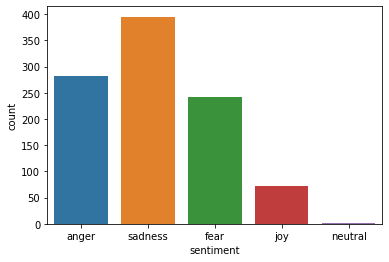

In [29]:
sns.countplot(text['sentiment'])

In [30]:
text[text['sentiment']=='joy']['S11a_Comments']

33                            Not able to see my daughter
107     I don't have a job and I need money for baby s...
135                                   Not being in school
156     Family problem/everything is stressful I have ...
181           Month ago, friend shot now parralyzed [sic]
                              ...                        
2665    Not able to enroll into a new school because o...
2705                 family disputes, drama among friends
2720                                      Friends passing
2724    Family was evicted from their apartment didnt ...
2734                                              Anxiety
Name: S11a_Comments, Length: 72, dtype: object

## correlation finding

inner join two dataframe with key = id, value = sentiment and risk-score

In [31]:
text.shape

(2765, 12)

In [32]:
df=pd.read_csv('zscore_with_id.csv')

In [33]:
df.shape

(1319, 7)

In [34]:
risk=df.loc[:,['gangid','sum']]
risk.head()

,gangid,sum
0,BVCB-0-144-1,-7.812063
1,BVCB-0-174-1,2.120676
2,Southeast 3-10-18-1,-8.555216
3,Southeast 3-10-17-1,-8.555216
4,Southeast 3-10-19-1,-8.555216


In [35]:

emotion=text.loc[:,['GRYD_ETO_ID','sentiment']]

In [36]:
emotion=emotion.rename(columns={'GRYD_ETO_ID':'gangid'})
emotion.shape

(2765, 2)

In [37]:
merged_inner = pd.merge(left=emotion, right=risk, left_on='gangid', right_on='gangid')

In [38]:
merged_inner.shape

(2021, 3)

In [39]:
df=merged_inner.dropna()

In [40]:
df.shape

(719, 3)

In [41]:
df.head()
#df is the final one

,gangid,sentiment,sum
0,BVCB-0-144-1,anger,-7.812063
1,BVCB-0-174-1,sadness,2.120676
2,BVCB-0-174-1,sadness,2.965543
5,Southeast 3-10-18-1,sadness,-8.555216
6,Southeast 3-10-17-1,anger,-8.555216


Text(0, 0.5, 'z_score')

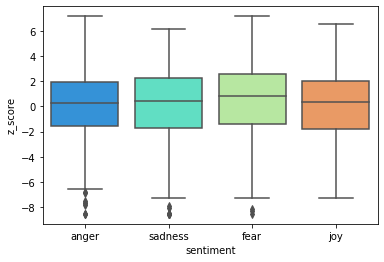

In [42]:
sns.boxplot(x='sentiment',y='sum',data=df,palette='rainbow')
plt.ylabel('z_score')

Text(0, 0.5, 'z_score')

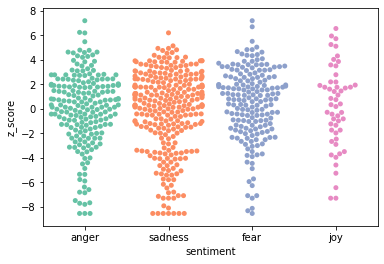

In [43]:
sns.swarmplot(x='sentiment',y='sum',data=df,palette='Set2')
plt.ylabel('z_score')

do the same with activity and risk-score

In [44]:
activity=pd.read_csv('SET_S6b_Activities_Categorized.csv')

In [45]:
activity=activity.drop(columns = "Unnamed: 0")

In [46]:
activity=activity.rename(columns={'GRYD_ETO_ID':'gangid'})
activity=activity.dropna()

In [47]:
activity_new = pd.DataFrame(activity.Categorized_Activities.str.split(', ').tolist(), index=activity.gangid).stack()
activity_new = activity_new.reset_index([0, 'gangid'])
activity_new.columns = ['gangid', 'categorized_activity']
activity_new.head()

,gangid,categorized_activity
0,BVCB-0-144-1,sports
1,BVCB-0-174-1,sports
2,Southeast 3-10-24-1,volunteer
3,Southeast 3-10-18-1,art
4,Southeast 3-10-17-1,art


In [48]:
merged_new = pd.merge(left=activity_new, right=risk, left_on='gangid', right_on='gangid')

Text(0, 0.5, 'z_score')

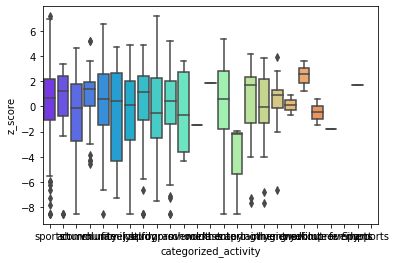

In [49]:
sns.boxplot(x='categorized_activity',y='sum',data=merged_new,palette='rainbow')
plt.ylabel('z_score')

!!!!!!!!!!!!!!! too many actvities, re-grouping

In [50]:
contents=merged_new['categorized_activity'].dropna().values
freq = nltk.FreqDist(contents)
freq

FreqDist({'sports': 206, 'job': 143, 'selfimprovement': 104, 'program': 102, 'study': 83, 'church': 75, 'volunteer': 69, 'community': 52, 'art': 48, 'hygiene': 39, ...})

In [51]:
from collections import Counter
plot_dict = dict(Counter(freq).most_common(50))
plot_dict

{'sports': 206,
 'job': 143,
 'selfimprovement': 104,
 'program': 102,
 'study': 83,
 'church': 75,
 'volunteer': 69,
 'community': 52,
 'art': 48,
 'hygiene': 39,
 'therapy': 37,
 'other': 37,
 'family': 26,
 'entertainment': 20,
 'school': 8,
 'tutoring': 3,
 'workout': 3,
 'gryd': 2,
 'voluteer': 2,
 'Sports': 2,
 'work': 1,
 'class': 1,
 'sefimprovement': 1,
 'femily': 1,
 'spports': 1}

In [52]:
merged_new.loc[merged_new['categorized_activity'] == 'work', 'categorized_activity'] = 'job'
merged_new.loc[merged_new['categorized_activity'] == 'Sports', 'categorized_activity'] = 'sports'
merged_new.loc[merged_new['categorized_activity'] == 'school', 'categorized_activity'] = 'study'
merged_new.loc[merged_new['categorized_activity'] == 'voluteer', 'categorized_activity'] = 'volunteer'
merged_new.loc[merged_new['categorized_activity'] == 'workout', 'categorized_activity'] = 'sports'
merged_new.loc[merged_new['categorized_activity'] == 'tutoring', 'categorized_activity'] = 'other'
merged_new.loc[merged_new['categorized_activity'] == 'community', 'categorized_activity'] = 'volunteer'
merged_new.loc[merged_new['categorized_activity'] == 'sefimprovement', 'categorized_activity'] = 'selfimprovement'
#merged_new is the final one

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

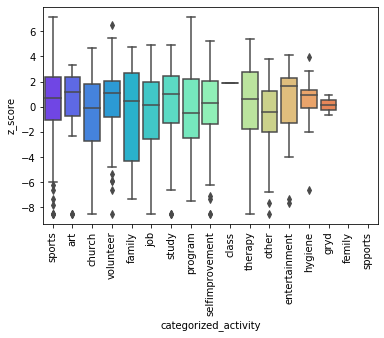

In [53]:
sns.boxplot(x='categorized_activity',y='sum',data=merged_new,palette='rainbow')
plt.ylabel('z_score')
plt.xticks(rotation=90)

In [54]:
contents=merged_new['categorized_activity'].dropna().values
freq = nltk.FreqDist(contents)
from collections import Counter
plot_dict = dict(Counter(freq).most_common(50))
plot_dict

{'sports': 211,
 'job': 144,
 'volunteer': 123,
 'selfimprovement': 105,
 'program': 102,
 'study': 91,
 'church': 75,
 'art': 48,
 'other': 40,
 'hygiene': 39,
 'therapy': 37,
 'family': 26,
 'entertainment': 20,
 'gryd': 2,
 'class': 1,
 'femily': 1,
 'spports': 1}

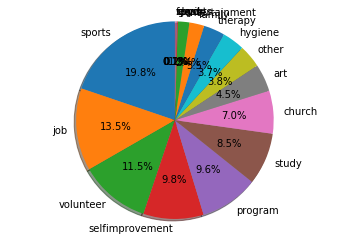

In [55]:
labels = plot_dict.keys()
sizes = plot_dict.values()


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

do the same with gender and age 

In [56]:
ag=pd.read_csv('SET_processed_latest_version.csv')

In [57]:
ag=ag.loc[:,['GRYD_ETO_ID','AGE_1_FB','SEX_1']]
ag=ag.rename(columns={'GRYD_ETO_ID':'gangid','AGE_1_FB':'age','SEX_1':'sex'})

In [58]:
ag = pd.merge(left=ag, right=risk, left_on='gangid', right_on='gangid')

In [59]:
ag.head()

,gangid,age,sex,sum
0,BVCB-0-144-1,20.0,2,-7.812063
1,BVCB-0-174-1,21.0,1,2.120676
2,BVCB-0-174-1,21.0,1,2.965543
3,BVCB-0-174-1,20.0,1,2.120676
4,BVCB-0-174-1,20.0,1,2.965543


Text(0, 0.5, 'z_score')

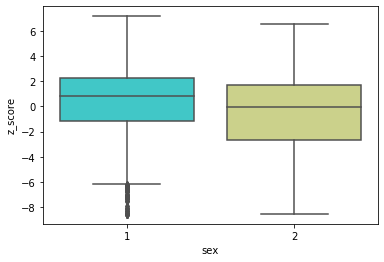

In [60]:
sns.boxplot(x='sex',y='sum',data=ag,palette='rainbow')
plt.ylabel('z_score')

In [61]:
for i in range (13,18):
    ag.loc[ag['age'] == i, 'age'] = '13-17'
    
for i in range (18,25):
    ag.loc[ag['age'] == i, 'age'] = '19-24'
    
for i in range (25,31):
    ag.loc[ag['age'] == i, 'age'] = '25-30'
    
for i in range (31,38):
    ag.loc[ag['age'] == i, 'age'] = '31-37'    

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

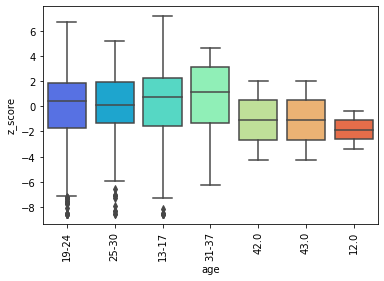

In [62]:
sns.boxplot(x='age',y='sum',data=ag,palette='rainbow')
plt.ylabel('z_score')
plt.xticks(rotation=90)

In [63]:
ag

,gangid,age,sex,sum
0,BVCB-0-144-1,19-24,2,-7.812063
1,BVCB-0-174-1,19-24,1,2.120676
2,BVCB-0-174-1,19-24,1,2.965543
3,BVCB-0-174-1,19-24,1,2.120676
4,BVCB-0-174-1,19-24,1,2.965543
...,...,...,...,...
2016,Northeast-25-68-2,19-24,1,NaN
2017,Southwest 2-23-279-1,19-24,2,NaN
2018,Southeast 1-24-85-1,19-24,1,NaN
2019,Northeast-25-64-1,13-17,1,NaN


In [64]:
emotion

,gangid,sentiment
0,BVCB-0-144-1,anger
1,BVCB-0-174-1,sadness
2,Southeast 3-10-24-1,sadness
3,Southeast 3-10-18-1,sadness
4,Southeast 3-10-17-1,anger
...,...,...
2760,Southwest 2-23-280-1,NaN
2761,Northeast-25-64-1,NaN
2762,Mission-14-413-1,NaN
2763,77th 3-20-376-1,NaN
